In [1]:
from functools import partial
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
#import torch.nn as nn
#import torch.utils.data as data

import time
from itertools import product

import pyro
#import pyro.distributions as dist

import tyxe

In [2]:
import jax
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen 
#import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from itertools import product
from jax.flatten_util import ravel_pytree


import jax_dataloader.core as jdl

import rebayes
from rebayes import base
from rebayes.utils import uci_regression_data, datasets
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd

2023-03-03 06:16:18.630060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-03 06:16:18.664974: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-03 06:16:19.501653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-03-03 06:16:19.501810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib


# Data

In [22]:
X_train, Y_train, X_test, Y_test, task_id_train, task_id_test = 
    rebayes.utils.datasets.make_1d_regression_sequence(n_dist=5, n_train=200)

def get_task_data(i):
    ndx_train = (task_id_train == i)
    Xtr, ytr = X_train[ndx_train], Y_train[ndx_train]
    ndx_test = (task_id_test == i)
    Xte, yte = X_test[ndx_test], Y_test[ndx_test]
    return Xtr, ytr, Xte, yte


Xtr, ytr, Xte, yte = get_task_data(0)


In [4]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ysd, ttl=''):
    plt.figure()
    plt.plot(Xtr, ytr, 'o', color="black", label='train')
    plt.plot(Xte, yte, 'x', color="red", label='test')
    plt.plot(Xte, yhat, '*', color="blue", label='pred')
    plt.legend()
    plt.title(ttl)



# Rebayes

In [5]:
class MLP(flax.linen.Module):
    n_out: int
    activation: Callable = flax.linen.tanh
    
    @flax.linen.compact
    def __call__(self, x):
        x = flax.linen.Dense(50)(x)
        x = self.activation(x)
        x = flax.linen.Dense(self.n_out)(x)
        return x

def make_bnn_flax():    
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_out)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    #print(n_params)
    return model, flat_params, recfn



In [23]:
model, flat_params, recfn = make_bnn_flax()

def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), x)

apply_fn = partial(apply, model=model, unflatten_fn=recfn)

params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.1,
        dynamics_weights=1,
        dynamics_covariance=0,
        emission_mean_function=apply_fn,
        emission_cov_function = lambda w,x: 0.1,
        adaptive_emission_cov=False,
    )

Xtr, ytr, Xte, yte = get_task_data(0)
Xtr_jax, ytr_jax, Xte_jax, yte_jax = jnp.array(Xtr), jnp.array(ytr), jnp.array(Xte), jnp.array(yte)


def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    yhat = apply_fn(bel.mean, Xte_jax).squeeze()
    rmse = jnp.mean(jnp.square(yhat - yte_jax[:,0]))
    return rmse



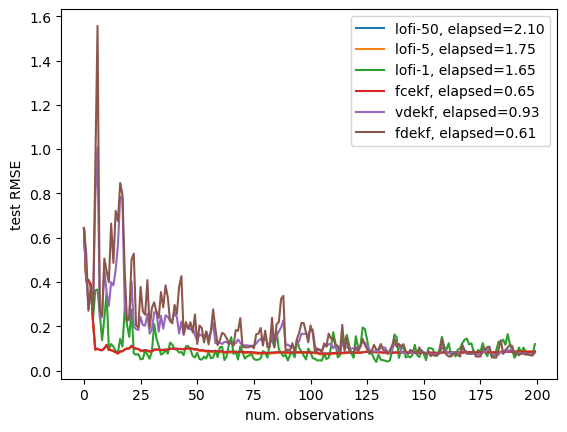

In [47]:
method_list, estimator_list = [], []

memory_list = [50, 5, 1]
for mem in memory_list:
    method = "lofi-{:d}".format(mem)
    params_lofi = lofi.LoFiParams(
        memory_size=mem,
        steady_state=True,
    )
    estimator = lofi.RebayesLoFi(params, params_lofi, method="lofi")
    method_list.append(method)
    estimator_list.append(estimator)

method = 'fcekf'
estimator = ekf.RebayesEKF(params, method=method)
method_list.append(method)
estimator_list.append(estimator)

method = 'vdekf'
estimator = ekf.RebayesEKF(params, method=method)
method_list.append(method)
estimator_list.append(estimator)

method = 'fdekf'
estimator = ekf.RebayesEKF(params, method=method)
method_list.append(method)
estimator_list.append(estimator)

rmse_trace_list, elapsed_list, yhat_list  = [], [], []

for i, estimator in enumerate(estimator_list):
    t0 = time.time()
    bel, rmse_trace = estimator.scan(Xtr_jax, ytr_jax, progress_bar=False, callback=callback)
    t1 = time.time()
    elapsed = t1-t0
    elapsed_list.append(elapsed)
    yhat = apply_fn(bel.mean, Xte_jax).squeeze()
    rmse_trace_list.append(rmse_trace)
    yhat_list.append(yhat)





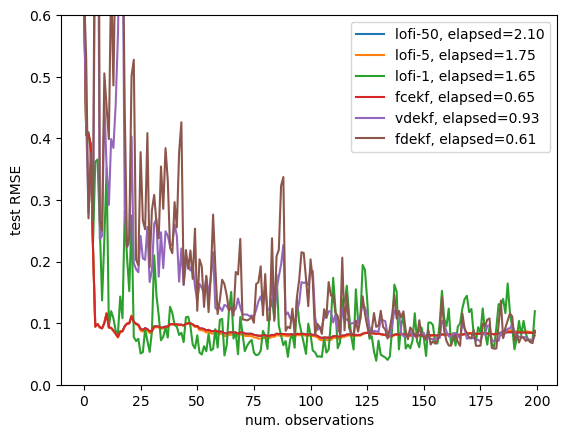

In [51]:
plt.figure()
for i, method in enumerate(method_list):
    ttl = '{:s}, elapsed={:0.2f}'.format(method, elapsed_list[i])
    plt.plot(rmse_trace_list[i], label=ttl)
ntrain = Xtr.shape[0]
#plt.xlim([5, ntrain]) # skip first few steps
plt.ylim([0, 0.6])
plt.legend()
plt.ylabel('test RMSE')
plt.xlabel('num. observations')


plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/regression_plot_1d_lofi.pdf')
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/regression_plot_1d_lofi.png')

In [25]:
rmse_trace_lofi = rmse_trace_list[0]
elapsed_lofi = elapsed_list[0]
yhat_lofi = yhat_list[0]

rmse_trace_vdekf = rmse_trace_list[2]
elapsed_vdekf = elapsed_list[2]
yhat_vdekf = yhat_list[2]

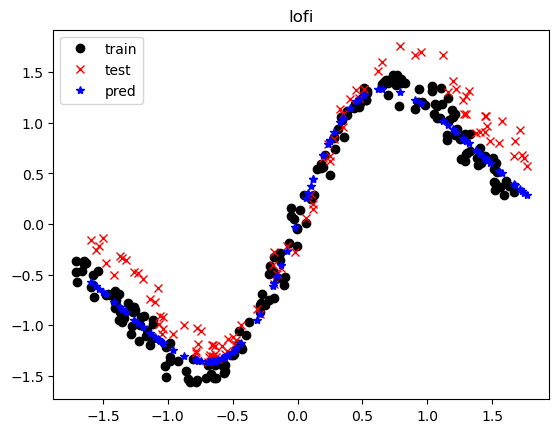

In [46]:


plot_pred(Xtr, ytr, Xte, yte, yhat_lofi, ysd=[], ttl='lofi')
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/rmse_vs_time_lofi.pdf')
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/rmse_vs_time_lofi.png')


# Tyxe

In [27]:
def make_bnn_tyxe():
    nhidden = 50
    net = torch.nn.Sequential(torch.nn.Linear(1, nhidden), torch.nn.Tanh(), torch.nn.Linear(nhidden, 1))
    prior = tyxe.priors.IIDPrior(pyro.distributions.Normal(0, 1))
    #obs_model = tyxe.likelihoods.HomoskedasticGaussian(Ntr, scale=0.1)
    obs_model = tyxe.likelihoods.HomoskedasticGaussian(1, scale=0.1)
    guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
    #guide = partial(pyro.infer.autoguide.guides.AutoLowRankMultivariateNormal, init_scale=0.01, rank=10)
    bnn = tyxe.VariationalBNN(net, prior, obs_model, guide)
    return bnn

def train_bnn_tyxe(bnn, loader, nepochs=100, lr=1e-3):
    #pyro.clear_param_store()
    optim = pyro.optim.Adam({"lr": lr})
    elbos = []
    def callback(bnn, i, e):
        elbos.append(e)
        
    with tyxe.poutine.local_reparameterization():
        bnn.fit(loader, optim, nepochs, callback)
    return bnn, elbos

def update_prior_tyxe(bnn):
    bayesian_weights = tyxe.util.pyro_sample_sites(bnn)
    posteriors = bnn.net_guide.get_detached_distributions(bayesian_weights)
    bnn.update_prior(tyxe.priors.DictPrior(posteriors))
    return bnn

In [28]:


def scan_tyxe(Xtr, ytr, Xte, yte, batch_size, nepochs_per_batch=100, lr=1e-3):
    pyro.clear_param_store()
    bnn = make_bnn_tyxe()
    Ntr = Xtr.shape[0]
    if type(Xte) is not torch.Tensor: Xte = torch.tensor(Xte)
    if type(yte) is not np.ndarray: yte = yte.detach().numpy()
    nbatches = int(Ntr/batch_size)
    outputs = []
    for b in range(nbatches):
        #print('batch {:d} of {:d}'.format(b, nbatches))
        ndx_train = np.arange(b*batch_size, (b+1)*batch_size)
        Xb, yb = Xtr[ndx_train], ytr[ndx_train]
        dataset = torch.utils.data.TensorDataset(Xtr, ytr)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        bnn, elbos = train_bnn_tyxe(bnn, loader, nepochs_per_batch, lr)
        yhat, ysd = bnn.predict(Xte, num_predictions=32)
        yhat, ysd = yhat.detach().numpy(), ysd.detach().numpy()
        rmse = np.mean(np.square(yte - yhat))
        outputs.append(rmse)
        bnn = update_prior_tyxe(bnn)
    return np.array(outputs), yhat, ysd

In [29]:
Xtr, ytr, Xte, yte = get_task_data(0)
Xtr_pt, ytr_pt, Xte_pt, yte_pt = torch.tensor(Xtr), torch.tensor(ytr), torch.tensor(Xte), torch.tensor(yte)

In [30]:

bs_list = [10, 20]
nepoch_list = [1, 10]
lr_list = [1e-2, 1e-3]

hparams_list = []

for i, (bs, nepochs, lr) in enumerate(product(bs_list, nepoch_list, lr_list)):
    hparam_dict = {'bs': bs, 'nepochs': nepochs, 'lr': lr}
    hparams_list.append(hparam_dict)

print(hparams_list)


[{'bs': 10, 'nepochs': 1, 'lr': 0.01}, {'bs': 10, 'nepochs': 1, 'lr': 0.001}, {'bs': 10, 'nepochs': 10, 'lr': 0.01}, {'bs': 10, 'nepochs': 10, 'lr': 0.001}, {'bs': 20, 'nepochs': 1, 'lr': 0.01}, {'bs': 20, 'nepochs': 1, 'lr': 0.001}, {'bs': 20, 'nepochs': 10, 'lr': 0.01}, {'bs': 20, 'nepochs': 10, 'lr': 0.001}]


In [31]:
rmse_trace_list_tyxe, elapsed_list_tyxe, yhat_list_tyxe  = [], [], []
for i, hparams in enumerate(hparams_list): 
    print(hparams)  
    pyro.set_rng_seed(42)
    t0 = time.time()
    rmse_trace, yhat, ysd = scan_tyxe(Xtr_pt, ytr_pt, Xte_pt, yte_pt, hparams['bs'], hparams['nepochs'], hparams['lr'])
    yhat_list_tyxe.append(yhat)
    t1 = time.time()
    elapsed = t1-t0
    #print(rmse_trace)
    rmse_trace_list_tyxe.append(rmse_trace)
    elapsed_list_tyxe.append(elapsed)



{'bs': 10, 'nepochs': 1, 'lr': 0.01}
{'bs': 10, 'nepochs': 1, 'lr': 0.001}
{'bs': 10, 'nepochs': 10, 'lr': 0.01}
{'bs': 10, 'nepochs': 10, 'lr': 0.001}
{'bs': 20, 'nepochs': 1, 'lr': 0.01}
{'bs': 20, 'nepochs': 1, 'lr': 0.001}
{'bs': 20, 'nepochs': 10, 'lr': 0.01}
{'bs': 20, 'nepochs': 10, 'lr': 0.001}


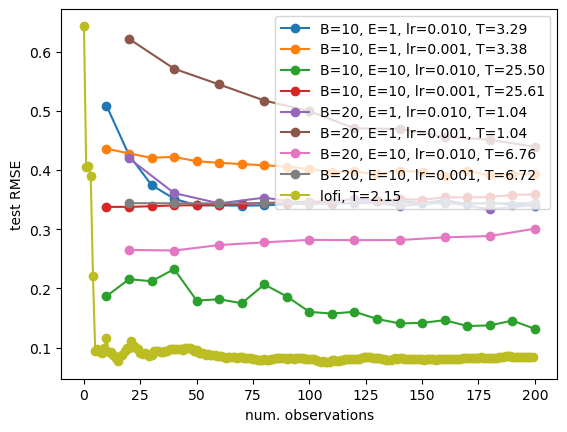

In [42]:
import copy


ntrain = Xtr.shape[0]
method_name_list, ndx_list = [],  []
for i in range(len(hparams_list)):
    hparams = hparams_list[i]
    bs = hparams['bs']
    ndx = np.arange(bs, ntrain+bs, step=bs)
    ndx_list.append(ndx)
    ttl = 'B={:d}, E={:d}, lr={:0.3f}, T={:0.2f}'.format(hparams['bs'], hparams['nepochs'], hparams['lr'], elapsed_list_tyxe[i])
    method_name_list.append(ttl)

ttl = 'lofi, T={:0.2f}'.format(elapsed_lofi)
method_name_list.append(ttl)

rmse_list = copy.deepcopy(rmse_trace_list_tyxe)
rmse_list.append(rmse_trace_lofi)
ndx_list.append(np.arange(0, ntrain))


plt.figure()
for i in range(len(rmse_list)):
    ttl = method_name_list[i]
    plt.plot(ndx_list[i], rmse_list[i], 'o-', label=ttl)
plt.ylabel('test RMSE')
plt.xlabel('num. observations')
plt.legend()
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/rmse_vs_time.pdf')
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/rmse_vs_time.png')



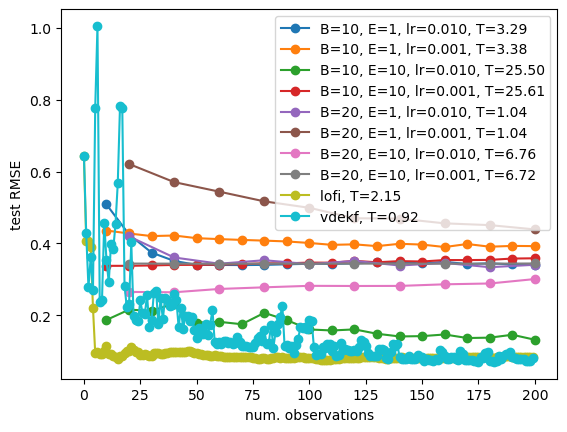

In [43]:

ttl = 'vdekf, T={:0.2f}'.format(elapsed_vdekf)
method_name_list.append(ttl)

rmse_list.append(rmse_trace_vdekf)
ndx_list.append(np.arange(0, ntrain))

plt.figure()
for i in range(len(rmse_list)):
    ttl = method_name_list[i]
    plt.plot(ndx_list[i], rmse_list[i], 'o-', label=ttl)
plt.ylabel('test RMSE')
plt.xlabel('num. observations')
plt.legend()
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/rmse_vs_time_vdekf.pdf')
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/rmse_vs_time_vdekf.png')

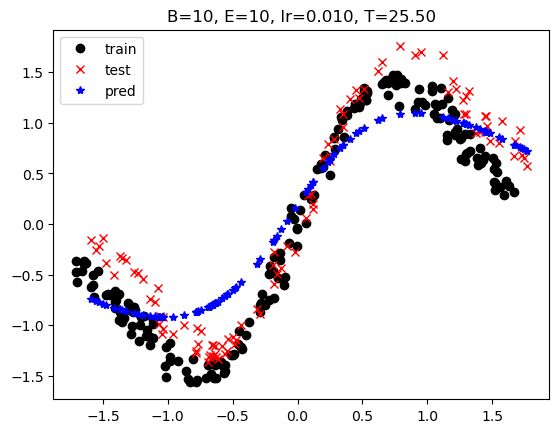

In [45]:
i=2
ttl = method_name_list[i]
yhat = yhat_list_tyxe[i]
plot_pred(Xtr, ytr, Xte, yte, yhat, ysd=[], ttl=ttl)
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/regression_plot_1d_vcl.pdf')
plt.savefig('/home/kpmurphy/github/rebayes/demos/figures/regression_plot_1d_vcl.png')
